# pyPCG Example code
## version: WIP
### Kristóf Müller (muller.kristof@itk.ppke.hu)

Import modules:

In [1]:
import pyPCG as pcg
import pyPCG.io as signal_io
import pyPCG.preprocessing as preproc
import pyPCG.segment as sgm
import pyPCG.features as ftr
import pyPCG.stats as sts

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

Read in data:

In [2]:
data, fs = signal_io.read_signal_file("example.wav","wav")
example = pcg.pcg_signal(data,fs)

Plot first 4 seconds of raw data:

(0.0, 4.0)

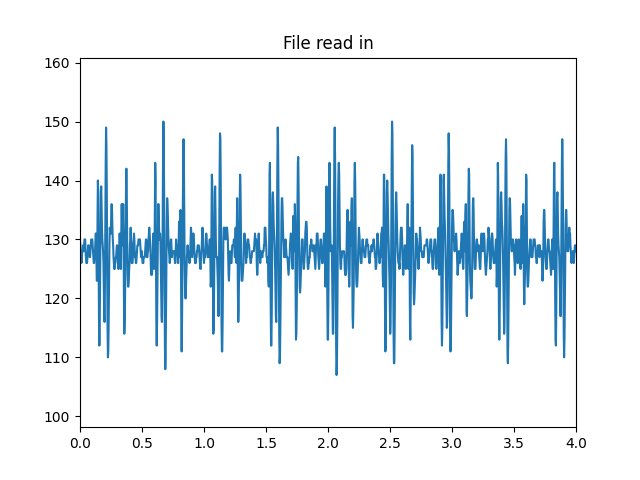

In [3]:
plt.figure()
pcg.plot(example)
plt.xlim((0,4))

Normalize signal to zero mean and [-1,1] interval:

(0.0, 4.0)

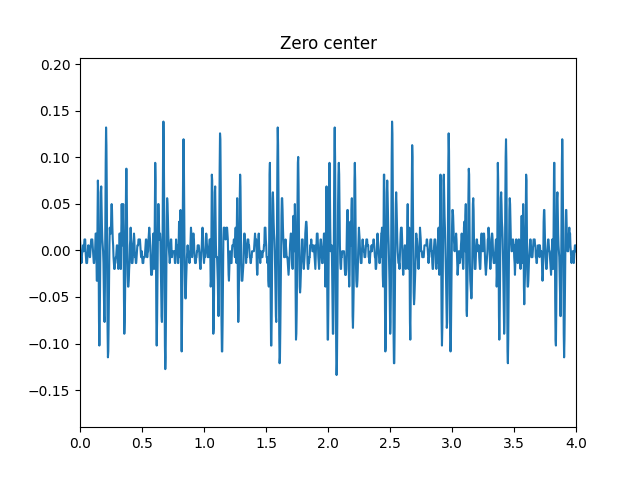

In [4]:
norm_signal = pcg.normalize(example)

plt.figure()
pcg.plot(norm_signal)
plt.xlim((0,4))

Create processing pipeline:

Certain steps need their parameters bound to the function (`partial`).</br>
Here specific filters are created from the generic filters.</br>
The pipeline consists of low and high pass filtering, wavelet denoising, and finally a homomorphic envelope calculation.</br>
This pipeline object can be reused if needed for other input signals, thus reducing code repetition.

In [5]:
from functools import partial
lp_filter = partial(preproc.filter, filt_ord=6, filt_cutfreq=100, filt_type="LP")
hp_filter = partial(preproc.filter, filt_ord=6, filt_cutfreq=20, filt_type="HP")

my_pipeline = pcg.process_pipeline(lp_filter,hp_filter,preproc.wt_denoise,preproc.homomorphic)

Run the created pipeline on the normalized signal and plot the result:

Note: the pcg_signal object logs every processing step applied to it

['File read in', 'Unit scale', 'Zero center', 'LP Filter (order-6, cut-100)', 'HP Filter (order-6, cut-20)', 'Wavelet denoise (family-coif4, level-5, th-0.2)', 'Homomorphic envelope (order-6,cut-8)']


(0.0, 4.0)

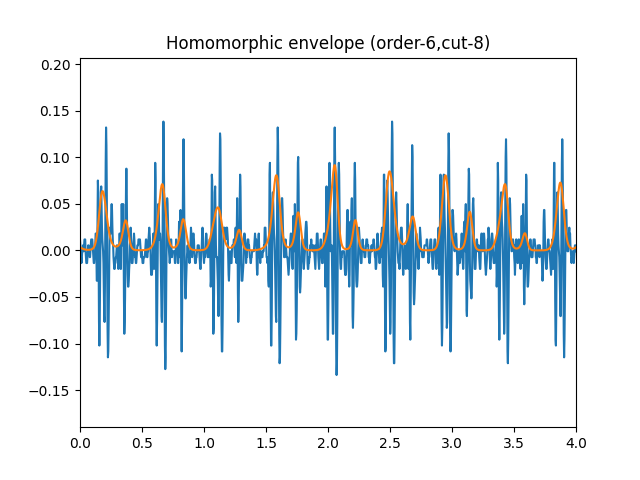

In [6]:
processed = my_pipeline.run(norm_signal)
print(processed.processing_log)
plt.figure()
pcg.plot(norm_signal)
pcg.plot(processed)
plt.xlim((0,4))

Segmentation of heartsounds:

Detect heartsounds on the envelope with advanced peak detection.</br>
Sort the detections to S1/S2, based on the time differences between them.</br>
Using the peaks and the envelope create start and end timepoints for the heartsounds.

In [7]:
peakvals, peaks = sgm.adv_peak(processed)
s1,s2 = sgm.peak_sort_diff(peaks)
st_1,en_1 = sgm.segment_peaks(s1,processed)
st_2,en_2 = sgm.segment_peaks(s2,processed)

(0.0, 4.0)

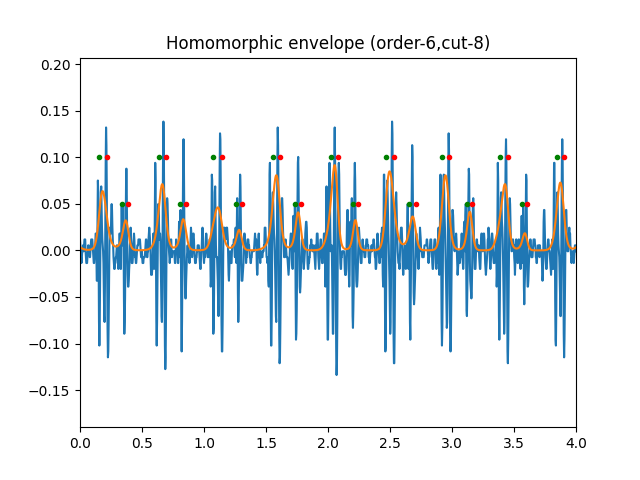

In [8]:
plt.figure()
pcg.plot(norm_signal)
pcg.plot(processed)
plt.plot(st_1/norm_signal.fs,np.ones_like(st_1)*0.1,'g.')
plt.plot(en_1/norm_signal.fs,np.ones_like(en_1)*0.1,'r.')
plt.plot(st_2/norm_signal.fs,np.ones_like(st_2)*0.05,'g.')
plt.plot(en_2/norm_signal.fs,np.ones_like(en_2)*0.05,'r.')
plt.xlim((0,4))

Calculate some features:

Note: for more featrues see `pyPCG.features`

In [9]:
s1_len = ftr.time_delta(st_1,en_1,processed)
s1_maxfreq = ftr.max_freq(st_1,en_1,norm_signal,nfft=1024)
s1_freqcenter = ftr.spectral_centroid(st_1,en_1,norm_signal,nfft=1024)
s1_spectrum = ftr.spectrum_raw(st_1,en_1,norm_signal,nfft=1024)

Create feature groups:

To create a processing and analysis pipeline and reduce code repetition, you can create feature groups.</br>
These work similarly to the pipeline object with feature calculator functions.</br>
Their output is a dictionary with the calculated results and their given names.

In [10]:
hs_features = ftr.feature_group((ftr.ramp_time,    "onset",      "env"),
                                (ftr.ramp_time,    "exit",       "env",{"type":"exit"}),
                                (ftr.peak_width,   "peak width", "env"),
                                (ftr.peak_centroid,"peak center","env"))

pcg_features = ftr.feature_group((ftr.time_delta,       "length",        "raw"),
                                 (ftr.spectral_centroid,"fft center",    "raw",{"nfft":1024}),
                                 (ftr.spectral_width,   "fft peak width","raw",{"nfft":1024}),
                                 (ftr.zero_cross_rate,  "zcr",           "raw"),
                                 (ftr.max_freq,         "fft peak",      "raw",{"nfft":1024}))

Using the feature groups:

In [11]:
s1_features_hs = hs_features.run(norm_signal,processed,st_1,en_1)
s1_features_pcg = pcg_features.run(norm_signal,processed,st_1,en_1)
s1_features = s1_features_hs | s1_features_pcg

s2_features_hs = hs_features.run(norm_signal,processed,st_2,en_2)
s2_features_pcg = pcg_features.run(norm_signal,processed,st_2,en_2)
s2_features = s2_features_hs | s2_features_pcg

Extra feature calculations:

Using the `pcg_features` can be also done on other segments.</br>
For this we can just change the segment start and end times.</br>
For example: systole start -> S1 end, systole end -> S2 start

In [12]:
sys_features = pcg_features.run(norm_signal,processed,en_1,st_2)

c:\Users\Müller Kristóf\PhD\pyPCG_toolbox\pyPCG\features.py:13: UserWarning: Start and end arrays not the same size. Converting to same size...
  warnings.warn("Start and end arrays not the same size. Converting to same size...")


Statistics of features:

Example calculations from S1 features.</br>
Calculate spectral kurtosis vector from raw spectrum

0.06398880083090609
1.4299487662482009
36.0587084148728


Text(0.5, 0, 'S1 index')

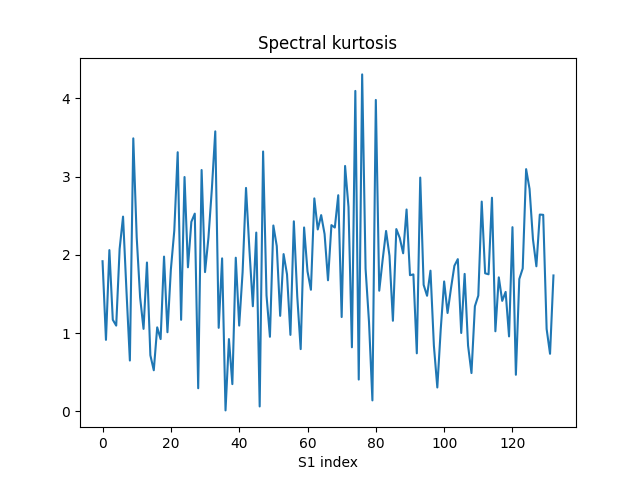

In [13]:
print(sts.mean(s1_len))
print(sts.std(s1_maxfreq[0]))
print(sts.med(s1_freqcenter[0]))
spectral_kurt = sts.kurt(s1_spectrum)

plt.figure()
plt.plot(spectral_kurt)
plt.title("Spectral kurtosis")
plt.xlabel("S1 index")

Moving window statistics:

To view changes over time we can apply a moving window with any statistic measure

Text(0.5, 1.0, 'Moving std of freq center')

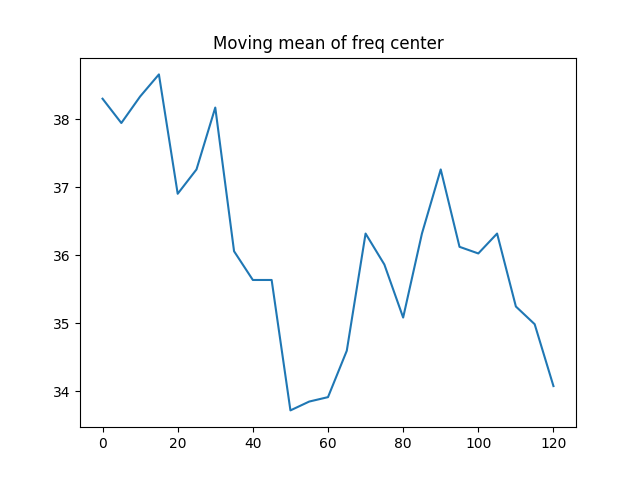

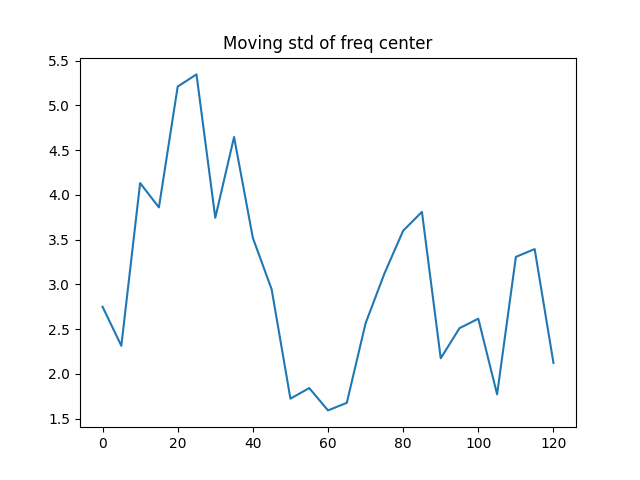

In [14]:
movmean_t, movmean_val = sts.window_operator(s1_freqcenter[0],win_size=10,fun=sts.mean)
movstd_t, movstd_val = sts.window_operator(s1_freqcenter[0],win_size=10,fun=sts.std)

plt.figure()
plt.plot(movmean_t,movmean_val)
plt.title("Moving mean of freq center")
plt.figure()
plt.plot(movstd_t,movstd_val)
plt.title("Moving std of freq center")

HRV with RMSSD:

Calculate the RMS of S1 time differences in msec.</br>
For this, offset the S1 indicies and convert to msec. Then `time_delta` and `rms` can be used.

In [15]:
# S1 start times offset from each other and converted to msec
st_1_prev = np.round((st_1[:-1]/processed.fs)*1000).astype(int)
st_1_next = np.round((st_1[1:]/processed.fs)*1000).astype(int)

# Time differences
diff = ftr.time_delta(st_1_prev,st_1_next,processed)

# RMS of differences -> RMSSD
print(sts.rms(diff))

1.3514636306880639


Create statistics from feature groups:

Create an accumulator dictionary with the names of the segments.</br>
Calculate the given statistics for all features.</br>
Export the statistics as an Excel spreadsheet

In [16]:
total_features = {"S1":s1_features,"S2":s2_features,"sys":sys_features}
total_stats = sts.calc_group_stats(total_features,(sts.mean,"Mean"),(sts.std,"Std"),(sts.min,"Min"),(sts.max,"Max"),(sts.med,"Median"),(sts.iqr,"IQR"),(sts.skew,"Skewness"),(sts.kurt,"Kurtosis"))

sts.export_stats("test_analysis.xlsx",total_stats)